In [1]:
import pandas as pd


df = pd.read_csv("vaccination_tweets.csv")


print(df.head())

                    id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405  

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import pandas as pd
nltk.download('stopwords')
nltk.download('wordnet')


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 


def nettoyer_texte(texte):
    texte = texte.lower()  
    texte = re.sub(r'\d+', '', texte)  
    texte = re.sub(r'[^\w\s]', '', texte)  
    texte = texte.split()  
    texte = [lemmatizer.lemmatize(mot) for mot in texte if mot not in stop_words]  
    return " ".join(texte)


df['text_clean'] = df['text'].apply(nettoyer_texte)
print(df.columns)

print(df[['text', 'text_clean']].head())




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet', 'text_clean'],
      dtype='object')
                                                text  \
0  Same folks said daikon paste could treat a cyt...   
1  While the world has been on the wrong side of ...   
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  Facts are immutable, Senator, even when you're...   
4  Explain to me again why we need a vaccine @Bor...   

                                          text_clean  
0  folk said daikon paste could treat cytokine st...  
1  world wrong side history year hopefully bigges...  
2  coronavirus sputnikv astrazeneca pfizerbiontec...  
3  fact immutable senator even youre ethically st...  
4  explain need vaccine borisjohnson matthancock ...  


In [8]:
# -----------------------------
# 1. Imports & setup
# -----------------------------
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# -----------------------------
# 2. Text preprocessing
# -----------------------------
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def nettoyer_texte(texte):
    if pd.isna(texte):
        return ""
    texte = texte.lower()                         # lowercase
    texte = re.sub(r'\d+', '', texte)             # remove digits
    texte = re.sub(r'[^\w\s]', '', texte)         # remove punctuation
    tokens = texte.split()                        # tokenize
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

# -----------------------------
# 3. Load dataset
# -----------------------------
file_path = 'vaccination_tweets.csv'   # adjust if needed
df = pd.read_csv(file_path)

if 'text' not in df.columns:
    raise KeyError("Column 'text' not found in dataset.")

df['text_clean'] = df['text'].apply(nettoyer_texte)

# -----------------------------
# 4. Create sentiment labels using VADER (pos / neu / neg)
# -----------------------------
sid = SentimentIntensityAnalyzer()

def obtenir_sentiment(text):
    if pd.isna(text) or len(text.strip()) == 0:
        return "neutre"
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positif'
    elif score <= -0.05:
        return 'négatif'
    else:
        return 'neutre'

df['sentiment'] = df['text_clean'].apply(obtenir_sentiment)

# Map to integers
label_map = {'négatif': 0, 'neutre': 1, 'positif': 2}
df['label_int'] = df['sentiment'].map(label_map)

print(df['sentiment'].value_counts())

# -----------------------------
# 5. Tokenization & padding
# -----------------------------
max_vocab_size = 5000
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_clean'])

sequences = tokenizer.texts_to_sequences(df['text_clean'])
max_seq_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

# -----------------------------
# 6. Define the LSTM model (3 classes)
# -----------------------------
vocab_size = min(len(tokenizer.word_index) + 1, max_vocab_size)
embedding_dim = 128
input_length = max_seq_length
num_classes = 3  # negatif, neutre, positif

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.build(input_shape=(None, input_length))
model.summary()

# -----------------------------
# 7. Train the model
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(padded_sequences, df['label_int'],
          epochs=10, batch_size=32, validation_split=0.2,
          callbacks=[early_stop])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiment
positif    4655
neutre     4570
négatif    1795
Name: count, dtype: int64


C:\Users\Pc\anaconda3\envs\tenserflow\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 20, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 919,811 (3.51 MB)

 Trainable params: 919,811 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.5178 - loss: 0.9354 - val_accuracy: 0.7958 - val_loss: 0.5519
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.8975 - loss: 0.3279 - val_accuracy: 0.8584 - val_loss: 0.4643
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9566 - loss: 0.1570 - val_accuracy: 0.8553 - val_loss: 0.5281
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9670 - loss: 0.1127 - val_accuracy: 0.8584 - val_loss: 0.5426


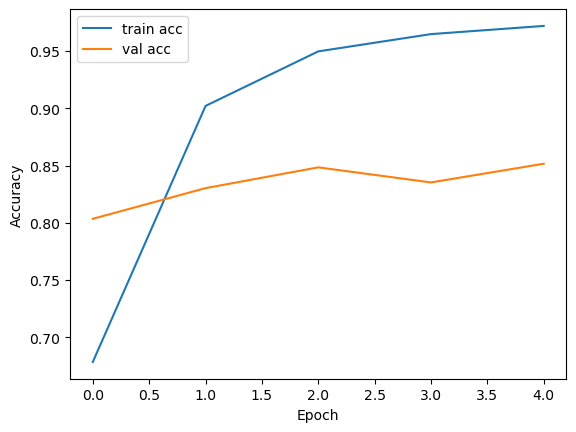

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


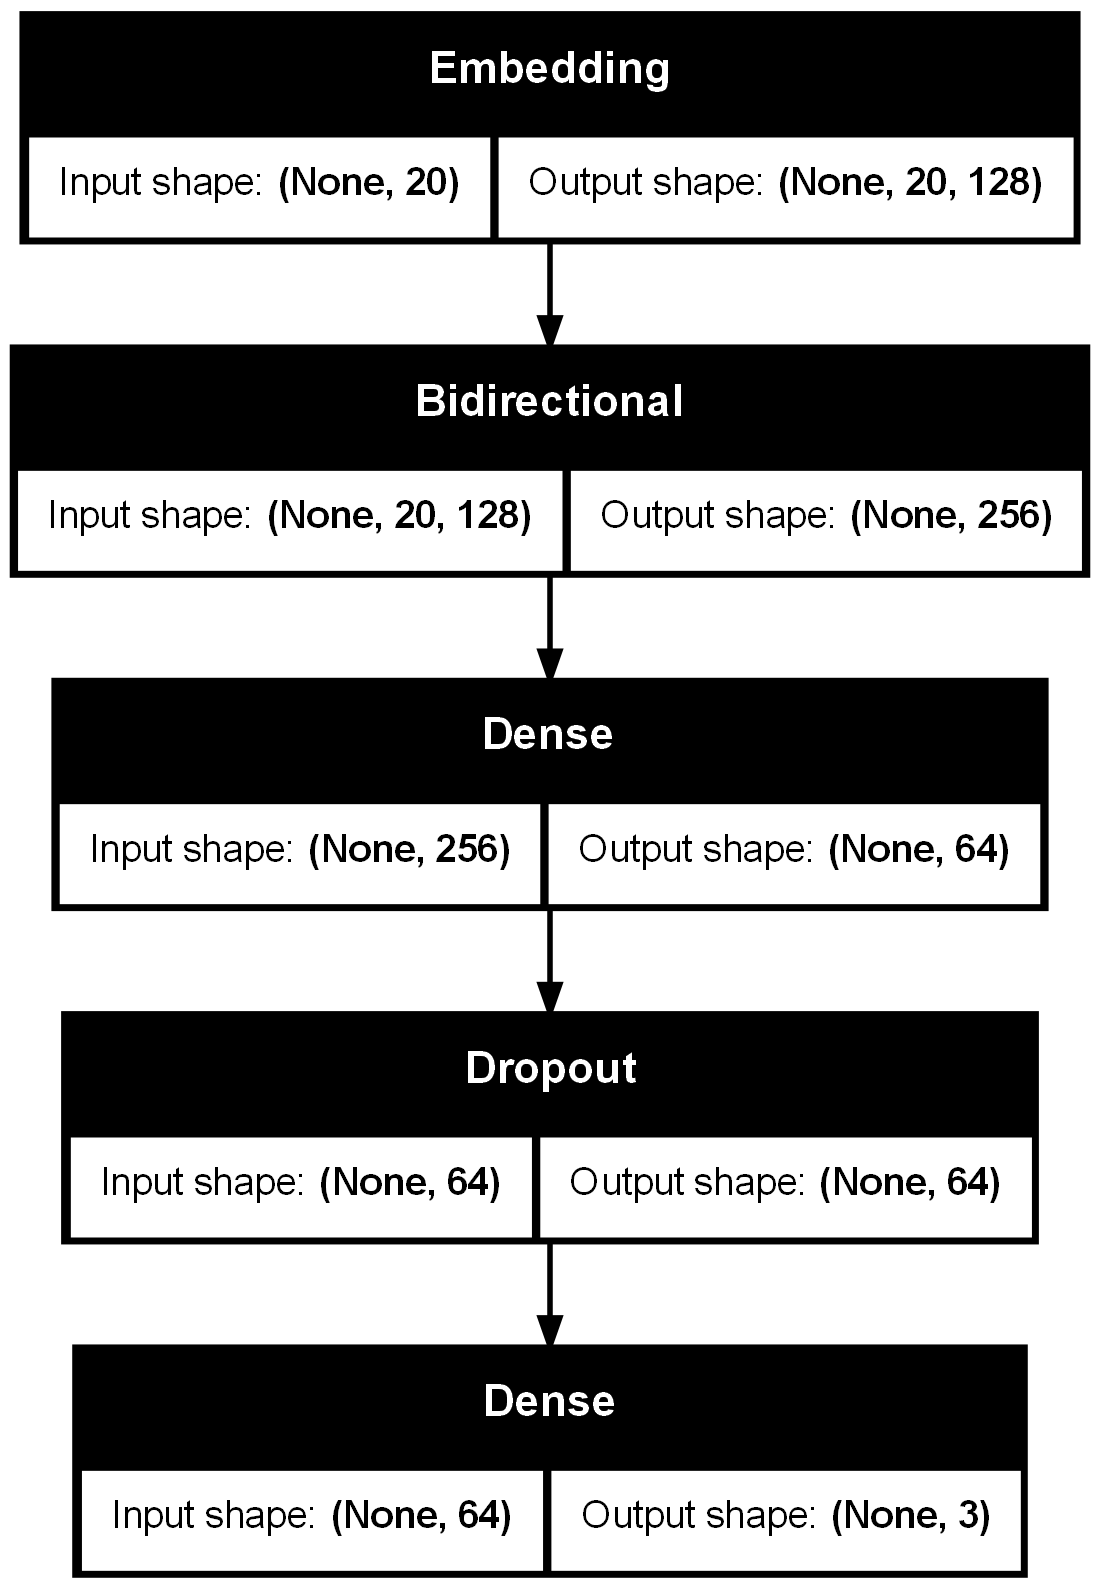

In [10]:

from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model_graph.png')

In [20]:
import numpy as np

# --- 1. Select one example tweet from your dataset ---
# Here we take the tweet at index 442
exemple_texte = df['text'].iloc[442]

# --- 2. Clean the selected tweet using your preprocessing function ---
exemple_nettoye = nettoyer_texte(exemple_texte)

# --- 3. Convert the cleaned text into a sequence of integers ---
# The tokenizer transforms words into their corresponding indices
sequence_exemple = tokenizer.texts_to_sequences([exemple_nettoye])

# --- 4. Apply padding to make the sequence match the model’s expected input length ---
# Adds zeros to the end if the tweet is shorter than max_seq_length
padded_sequence_exemple = pad_sequences(sequence_exemple, maxlen=max_seq_length, padding='post')

# --- 5. Make a prediction using our trained LSTM model ---
prediction = model.predict(padded_sequence_exemple)

# --- 6. Get the index of the class with the highest predicted probability ---
pred_index = np.argmax(prediction, axis=1)[0]

# --- 7. Map the numeric index back to the actual sentiment label ---
# This mapping must match the label order used during training
index_to_label = {0: 'négatif', 1: 'neutre', 2: 'positif'}
sentiment = index_to_label[pred_index]

# --- 8. Display the results ---
print("Original tweet :", exemple_texte)
print("Cleaned tweet :", exemple_nettoye)
print("Class scores :", prediction[0])  # e.g. [0.05, 0.10, 0.85]
print("Predicted sentiment :", sentiment)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Tweet original : Take a breath and celebrate what happened today. Democracy won.  Our constitution won. #PfizerBioNTech gave us hope… https://t.co/W3mdtevk26
Tweet nettoyé : take breath celebrate happened today democracy constitution pfizerbiontech gave u hope httpstcowmdtevk
Scores par classe : [4.1570677e-03 8.1574474e-04 9.9502724e-01]
Sentiment prédit : positif


                     Word  Percentage
0          pfizerbiontech    5.434494
1                 vaccine    4.354788
2                   covid    2.733087
3                  pfizer    1.381956
4                    dose    1.291195
...                   ...         ...
25380    httpstcoqztnttop    0.000856
25381            paxlovid    0.000856
25382            diseased    0.000856
25383  httpstcoavvicgxpzu    0.000856
25384    httpstcouupsebhi    0.000856

[25385 rows x 2 columns]


C:\Users\Pc\AppData\Local\Temp\ipykernel_12924\2442360035.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Percentage", y="Word", data=words_df.head(20), palette="viridis")


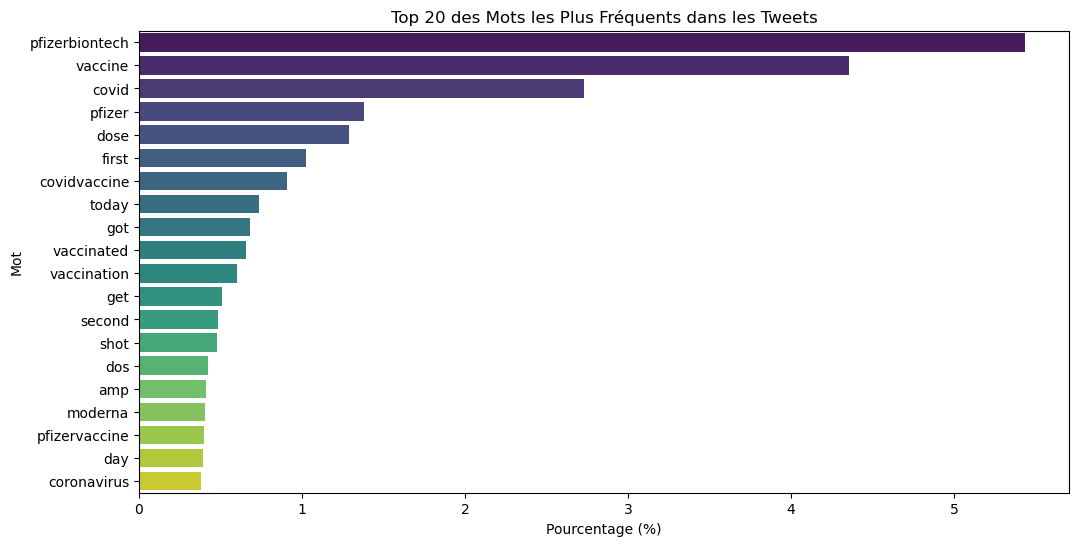

In [22]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- Combine all cleaned tweets into one long string and split into individual words ---
all_words = " ".join(df['text_clean']).split()

# --- Count how many times each word appears in the dataset ---
word_counts = Counter(all_words)

# --- Calculate the total number of words ---
total_words = sum(word_counts.values())

# --- Compute the percentage frequency of each word ---
# (word count / total word count) * 100 gives how frequent each word is
word_percentages = {word: (count / total_words) * 100 for word, count in word_counts.items()}

# --- Sort words by their percentage in descending order ---
sorted_words = sorted(word_percentages.items(), key=lambda x: x[1], reverse=True)

# --- Convert the sorted list into a pandas DataFrame for easy visualization ---
words_df = pd.DataFrame(sorted_words, columns=["Word", "Percentage"])
print(words_df)

# --- Create a horizontal bar plot of the top 20 most frequent words ---
plt.figure(figsize=(12, 6))
sns.barplot(x="Percentage", y="Word", data=words_df.head(20), palette="viridis")

# --- Add titles and labels ---
plt.title("Top 20 Most Frequent Words in Tweets")
plt.xlabel("Percentage (%)")
plt.ylabel("Word")

# --- Display the plot ---
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Pc\AppData\Local\Temp\ipykernel_12924\2434000890.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df.head(20), x="Word", y="Percentage", palette="viridis")


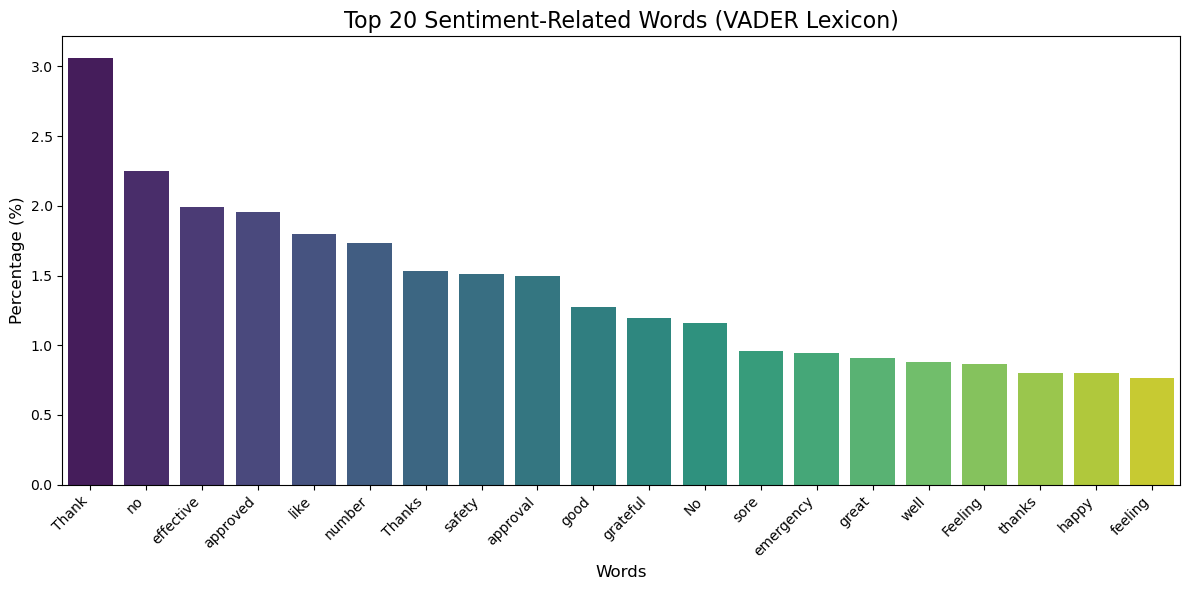

In [26]:
# --- Import necessary libraries ---
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# --- Download VADER lexicon (only needed once) ---
nltk.download('vader_lexicon')

# --- Initialize the sentiment analyzer ---
sid = SentimentIntensityAnalyzer()

# --- Load dataset ---
file_path = 'vaccination_tweets.csv'
df = pd.read_csv(file_path)

# --- Combine all tweets into one list of words ---
all_words = " ".join(df['text'].astype(str)).split()

# --- Get the VADER lexicon (dictionary of sentiment words) ---
vader_lexicon = sid.lexicon

# --- Keep only words that exist in the VADER lexicon ---
filtered_words = [word for word in all_words if word.lower() in vader_lexicon]

# --- Count occurrences of each word ---
word_counts = Counter(filtered_words)

# --- Compute total words and percentage for each ---
total_words = sum(word_counts.values())
word_percentages = {word: (count / total_words) * 100 for word, count in word_counts.items()}

# --- Sort by frequency (descending order) ---
sorted_words = sorted(word_percentages.items(), key=lambda x: x[1], reverse=True)

# --- Convert to DataFrame for easy plotting ---
words_df = pd.DataFrame(sorted_words, columns=["Word", "Percentage"])

# --- Plot the top 20 words ---
plt.figure(figsize=(12, 6))
sns.barplot(data=words_df.head(20), x="Word", y="Percentage", palette="viridis")

plt.title("Top 20 Sentiment-Related Words (VADER Lexicon)", fontsize=16)
plt.xlabel("Words", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


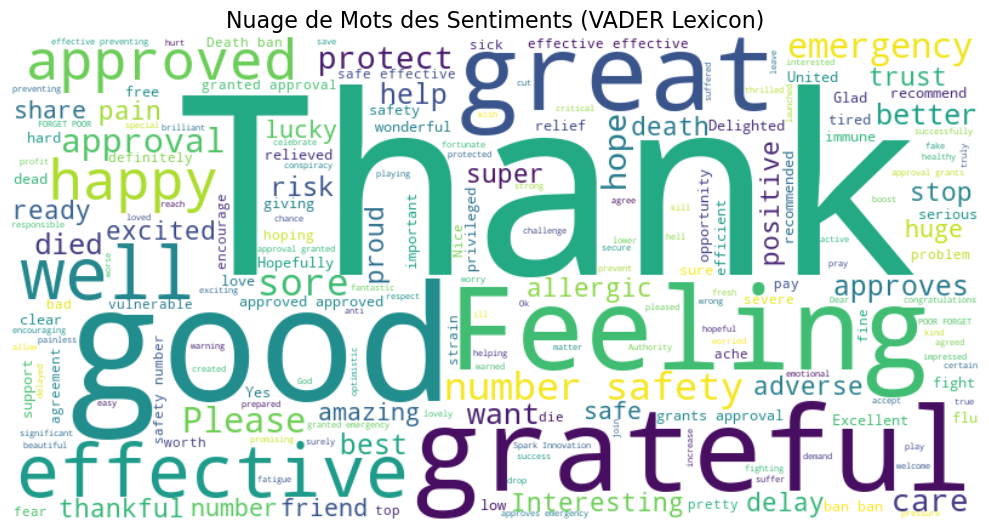

In [24]:
f# --- Import necessary libraries ---
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import pandas as pd

# --- Download the VADER lexicon (only needed once) ---
nltk.download('vader_lexicon')

# --- Initialize the Sentiment Analyzer ---
sid = SentimentIntensityAnalyzer()

# --- Load your dataset ---
file_path = 'vaccination_tweets.csv'
df = pd.read_csv(file_path)

# --- Combine all tweets into one large string ---
all_words = " ".join(df['text'].astype(str))  # Convert to string just in case of NaN

# --- Access the VADER lexicon (dictionary of sentiment words) ---
vader_lexicon = sid.lexicon

# --- Filter words: keep only those that exist in the VADER lexicon ---
filtered_words = " ".join([
    word for word in all_words.split()
    if word.lower() in vader_lexicon
])

# --- Generate the WordCloud ---
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis"  # You can also try 'coolwarm', 'plasma', 'inferno'
).generate(filtered_words)

# --- Display the WordCloud ---
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Word Cloud of Sentiment Words (VADER Lexicon)", fontsize=16)
plt.tight_layout()
plt.show()



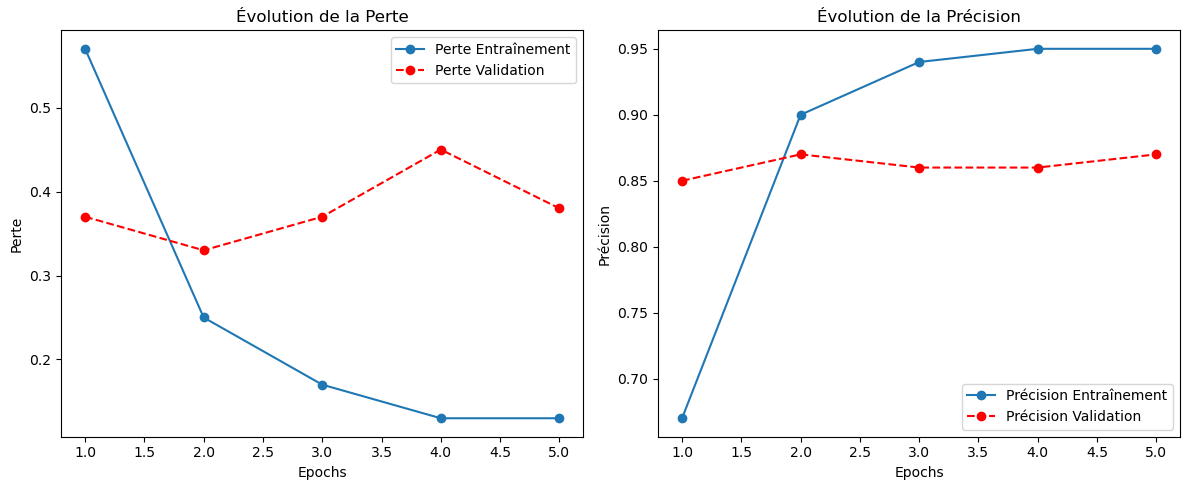

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# --- Simulated training results (replace these with your real values) ---
epochs = np.arange(1, 6)  # Array of epoch numbers: [1, 2, 3, 4, 5]

# Training and validation loss values
loss_train = [0.57, 0.25, 0.17, 0.13, 0.13]  # Training loss over epochs
loss_val = [0.37, 0.33, 0.37, 0.45, 0.38]    # Validation loss over epochs

# Training and validation accuracy values
acc_train = [0.67, 0.90, 0.94, 0.95, 0.95]   # Training accuracy over epochs
acc_val = [0.85, 0.87, 0.86, 0.86, 0.87]     # Validation accuracy over epochs

# --- Create the plots ---
plt.figure(figsize=(12, 5))  # Define figure size (width x height)

# --- Plot 1: Loss curve ---
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(epochs, loss_train, label="Training Loss", marker='o', linestyle='-')
plt.plot(epochs, loss_val, label="Validation Loss", marker='o', linestyle='--', color='red')
plt.xlabel("Epochs")               # Label for x-axis
plt.ylabel("Loss")                 # Label for y-axis
plt.title("Loss Evolution")        # Plot title
plt.legend()                       # Show legend

# --- Plot 2: Accuracy curve ---
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(epochs, acc_train, label="Training Accuracy", marker='o', linestyle='-')
plt.plot(epochs, acc_val, label="Validation Accuracy", marker='o', linestyle='--', color='red')
plt.xlabel("Epochs")               # Label for x-axis
plt.ylabel("Accuracy")             # Label for y-axis
plt.title("Accuracy Evolution")    # Plot title
plt.legend()                       # Show legend

# --- Adjust layout and display ---
plt.tight_layout()  # Adjust subplot spacing for better readability
plt.show()          # Display the plots

